**Diplomatic missions of Portugal**

**Goal**

To look at what type of portuguese diplomatic missions are in the world and where these missions are located.

**Method**

The list of diplomatic missions will be scraped from Wikipedia using pandas the read_html() method. After that a thorough data cleaning will take place. The cleaned data will be joined with a country codes dataset from [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/iso-country-codes-global). Finally, the data will be visualized by using a waffle chart and two coropleth map charts.

**Diplomatic missions definition by oxfordreference.com:**

>A diplomatic mission is a body composed of government officers representing the interests and welfare of their state who have been posted abroad (by the sending state) and operate within the jurisdiction of another state (the receiving state). This mission will be accorded protection by the receiving state in accordance with the rules of diplomatic immunity. 


In [1]:
pip install pywaffle

  Obtaining dependency information for fontawesomefree from https://files.pythonhosted.org/packages/8f/fc/295f4f71fc157de68dcf25a4850953e61f6eca644e7416f10a281ed42441/fontawesomefree-6.5.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 45.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pywaffle import Waffle
import plotly.express as px

First, the data needs to be scraped from the below Wikipedia page by using `read_html()` method of pandas.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_diplomatic_missions_of_Portugal'

In [4]:
tables = pd.read_html(url)

Let's see how many tables have been read.

In [5]:
len(tables)

13

There are 13 tables but we need only 5 for this project.  The the required tables can be read by using their indexes and than saved into dataframes. A new 'Continent' column will also be added into each 5 dataframes.

In [6]:
africa = tables[0]
africa['Continent'] = 'Africa'
americas = tables[1]
americas['Continent'] = 'Americas'
asia = tables[2]
asia['Continent'] = 'Asia'
europe = tables[3]
europe['Continent'] = 'Europe'
oceania = tables[4]
oceania['Continent'] = 'Oceania'

In the Oceania table the host city column name is mistyped. 

In [7]:
oceania.head()

,Host country,Hoat city,Mission,Concurrent accreditation,Ref.,Continent
0,Australia,Canberra,Embassy,Countries: Cook Islands Fiji Kiribati Marshal...,[85][86],Oceania
1,Australia,Sydney,Consulate General,Countries: Cook Islands Fiji Kiribati Marshal...,[85],Oceania


This misspelling needs to be corrected now to avoid concatenation problem at the next step.

In [8]:
oceania.rename(columns={'Hoat city': 'Host city'}, inplace=True)

Now we can concatenate the 5 tables, reset the index and drop the 'Ref.' column which is irrelevant.

In [9]:
df = pd.concat([africa, americas, asia, europe, oceania])\
.reset_index(drop = True).drop(columns=["Ref."]).rename(columns={"Host country": "Host_country",
                                                                 "Host city": "Host_city",
                                                                 "Concurrent accreditation": "ca"})
df.head()

,Host_country,Host_city,Mission,ca,Continent
0,Algeria,Algiers,Embassy,Countries: Mali,Africa
1,Angola,Luanda,Embassy,NaN,Africa
2,Angola,Benguela,Consulate-General,NaN,Africa
3,Cape Verde,Praia,Embassy,NaN,Africa
4,Cape Verde,Mindelo,Consular office,NaN,Africa


The 'ca' (concurrent accreditation) column seems to be problematic beacuse some countries have more than one accreditation while others have none. This column can contain mulitple values by rows including countries, international organizations and soveryn entities. So we are going to try and clean up this data.

We can check the data types and missing values by using pandas info ()method.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Host_country  125 non-null    object
 1   Host_city     125 non-null    object
 2   Mission       125 non-null    object
 3   ca            74 non-null     object
 4   Continent     125 non-null    object
dtypes: object(5)
memory usage: 5.0+ KB


There are 125 rows and 5 columns. All varaible's data type is 'object'. There are 51 missing values in 'Concurrent_accreditation' column. These not real missing values though beacuse not all countries have concurrent accreditations, for this reason these should be kept as NaN values.

The next step is to check how many unique mission types exist by using the np.unique () method.


In [11]:
np.unique(df.Mission)

array(['Consular office', 'Consulate', 'Consulate General',
       'Consulate-General', 'Embassy', 'Representative Office',
       'Vice-consulate'], dtype=object)

Consulate General appers with 2 different kind of writings which needs to be corrected.

In [12]:
df["Mission"] = df["Mission"].replace({"Consulate General": "Consulate-General"})

Now the diffrent mission types can be counted to check whether the replacement took place.

In [13]:
df.Mission.value_counts()

Mission
Embassy                  76
Consulate-General        33
Consular office           6
Vice-consulate            6
Consulate                 3
Representative Office     1
Name: count, dtype: int64

A waffle chart can be created now to show the proportion of Portuguese mission types.

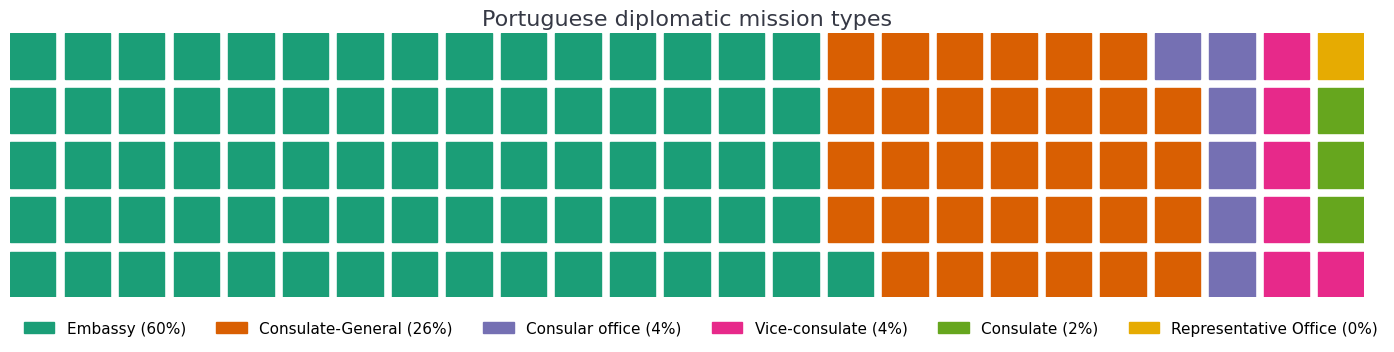

In [14]:
data = {"Embassy": 76, "Consulate-General": 33, "Consular office": 6,
        "Vice-consulate" : 6, "Consulate": 3, 'Representative Office': 1}
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data,
    figsize=(15, 10),
    cmap_name="Dark2",
    title={'label': 'Portuguese diplomatic mission types', 'loc': 'center',
           'fontdict': {'fontsize': 16, 'color': '#363945'}
    },
    labels=[f"{k} ({int(v / sum(data.values()) * 100)}%)" for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'ncol': len(data),
            'framealpha': 0,'fontsize': 11}
)

It's time to clean up the 'ca' (concurrent accreditation) column. First, we need to check all rows that are updated with International organizations.

In [15]:
df[df['ca'].str.contains('International', na = False)]

,Host_country,Host_city,Mission,ca,Continent
8,Ethiopia,Addis Ababa,Embassy,Countries: Djibouti Rwanda Somalia South Suda...,Africa
11,Kenya,Nairobi,Embassy,International Organizations: United Nations U...,Africa
46,United States,"Washington, D.C.",Embassy,Countries: Bahamas International Organization...,Americas
47,United States,Boston,Consulate-General,Countries: Bahamas International Organization...,Americas
48,United States,New York City,Consulate-General,Countries: Bahamas International Organization...,Americas
49,United States,Newark,Consulate-General,Countries: Bahamas International Organization...,Americas
50,United States,San Francisco,Consulate-General,Countries: Bahamas International Organization...,Americas
51,United States,New Bedford,Consulate,Countries: Bahamas International Organization...,Americas
52,United States,Providence,Vice-consulate,Countries: Bahamas International Organization...,Americas
54,Venezuela,Caracas,Embassy,Countries: Antigua and Barbuda Barbados Guyan...,Americas


There are a few, but only two of them updated solely with International organizations. Let's check what rows are updated with Sovereign Entity.

In [16]:
df[df['ca'].str.contains('Entity', na = False)]

,Host_country,Host_city,Mission,ca,Continent
98,Holy See,Rome[e],Embassy,Sovereign Entity: Sovereign Military Order of...,Europe


There is only one. Now we can replace these rows with white spaces by using pandas at property to set the value at a specified row/column pair.

In [17]:
df.at[11,'ca']=''
df.at[98,'ca']=''
df.at[103,'ca']=''

The of values in the'ca' (concurrent accreditation) column are separated both by : and whitespaces. Lets's split this column by : and assign it into a new dataframe.

In [18]:
variable_split = df['ca'].str.split(':',expand=True)
variable_split.head(2)

,0,1,2
0,Countries,Mali,None
1,NaN,NaN,NaN


In [19]:
variable_split.shape

(125, 3)

Now we can check the value counts in each three columns.

In [20]:
variable_split[0].value_counts()

0
Countries    71
              3
Name: count, dtype: int64

This column can be dropped because we neither need 'Countries' nor the three columns with whitespaces.

In [21]:
variable_split[1].value_counts()

1
  Monaco                                                                                                                                                         7
  Bahamas International Organizations                                                                                                                            7
  Liechtenstein                                                                                                                                                  5
  Andorra                                                                                                                                                        4
  Mongolia                                                                                                                                                       4
  Botswana Comoros Eswatini Lesotho Madagascar                                                                                                                   3
  Bangladesh Bhutan 

This column we will keep. Some rows are still updated with International organizations and these require further cleaning.

In [22]:
variable_split[2].value_counts()

2
  Organization of American States[b]                                                                          7
  Caribbean Community[c]                                                                                      2
  African Union[a]                                                                                            1
  Association of Southeast Asian Nations[d]                                                                   1
  United Nations International Atomic Energy Agency  UNIDO  UNODC                                             1
  Food and Agriculture Organization  International Fund for Agricultural Development  World Food Programme    1
Name: count, dtype: int64

Great, we don't need this column so we can now drop column 0 and 2.


In [23]:
variable_split = variable_split.drop(columns=([0, 2]))

The next step is to clean up column 1. To do so we need to split this column.

In [24]:
variable_split = variable_split[1].str.split(expand=True)
print(variable_split.shape)
variable_split.head(2)

(125, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Mali,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The problem is this gives the count of each string of countries instead of each country. What we would want instead is one column for each country, where the values in the column are 1 when that country is a concurrent acreditation and 0 when it is not. So we use the pd.get_dummies function to convert the country variable into dummy variables, reshape the dataframe by using pandas stack () function while keeping the NaN values by adding dropna=False explicitly (beacuse missing values would be dropped by default) and use pandas groupby(level=0).sum() method beacuse of the multi-indexed columns and finally we assign it into a new dataframe.

In [25]:
dummy = pd.get_dummies(variable_split.stack(dropna = False)).apply(pd.Series).groupby(level=0).sum()

This is to check if this new dataframe has the same number of rows as the original dataframe.

In [26]:
dummy.shape

(125, 138)

The number of rows is correct (125) and noew we have 138 columns. Let's check what countries we have by printing them out.

In [27]:
for col in dummy.columns:
    print(col)

Afghanistan
African
Albania
Andorra
Antigua
Armenia
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Barbuda
Belarus
Belize
Benin
Bhutan
Bolivia
Bosnia
Botswana
Brunei
Burkina
Burundi
Cambodia
Cameroon
Central
Chad
Comoros
Congo-Brazzaville
Cook
Costa
Djibouti
Dominica
Dominican
Ecuador
El
Eritrea
Estonia
Eswatini
Faso
Fiji
Gabon
Gambia
Georgia
Ghana
Grenadines
Guatemala
Guinea
Guyana
Haiti
Herzegovina
Honduras
Iceland
International
Iraq
Islands
Jamaica
Jordan
Kiribati
Kitts
Korea
Kosovo
Kuwait
Kyrgyzstan
Lanka
Laos
Latvia
Lebanon
Leone
Lesotho
Liberia
Liechtenstein
Lithuania
Lucia
Macedonia
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Marino
Marshall
Mauritania
Mauritius
Micronesia
Moldova
Monaco
Mongolia
Montenegro
Myanmar
Nauru
Nepal
Nevis
New
Niger
Niue
North
Oman
Organizations
Palau
Papua
Paraguay
Philippines
Republic
Rica
Rwanda
Saint
Salvador
Samoa
San
Seychelles
Sierra
Slovenia
Solomon
Somalia
South
Sri
Sudan
Suriname
Syria
Tajikistan
Tanzania
Tobago
Togo
Tonga
Trinidad
Turkmen

Some countries name contains more than 1 word so we need to tidy these one ups by pandas rename () method.

In [28]:
dummy = dummy.rename(columns={'Antigua': 'Antigua and Barbuda', 'Bosnia': 'Bosnia and Herzegovina', 'Burkina': 'Burkina Faso',
                              'Central': 'Central African Republic','Cook': 'Cook Islands', 'Costa': 'Costa Rica',
                              'Dominican': 'Dominican Republic', 'El': 'El Salvador', 'Marshall': 'Marshall Islands',
                              'New': 'New Zealand', 'Korea': 'North Korea', 'Macedonia': 'North Macedonia',
                              'Papua':'Papua New Guinea','San': 'San Marino','Lucia': 'Saint Lucia',
                              'Kitts':'Saint Kitts and Nevis','Vincent':'Saint Vincent and the Grenadines',
                              'Vincent':'Saint Vincent and the Grenadines','Sierra':'Sierra Leone',
                              'Solomon': 'Solomon Islands','Sri':'Sri Lanka', 'South':'South Sudan'})

Let's drop those words that we don't need from the country names.

In [29]:
dummy = dummy.drop(['African','and','Barbuda','Faso','Grenadines', 'Guinea', 'Herzegovina', 'International', 'Islands', 'Lanka',
                    'Leone','Marino','Nevis','North', 'Organizations','Republic', 'Rica', 'Salvador','Saint','Sudan',
                    'the','Zealand' ], axis=1)

Now we can concatenate the original dataframe with clean encoded one.

In [30]:
df1 = pd.concat([df, dummy], axis=1)

This to check the row and column numbers of the new dataframe.

In [31]:
df1.shape

(125, 121)

Now we can load the country codes dataset which will enable us to create the two map visualizations.

In [32]:
cc = pd.read_csv('/kaggle/input/iso-country-codes-global/wikipedia-iso-country-codes.csv')

In [33]:
cc.head(2)

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM


We concatenate our df1 dataframe with the country codes dataframe.

In [34]:
merged = pd.merge(df1, cc, how = 'left', left_on = ['Host_country'], right_on = ['English short name lower case'])

Now we need to check if each rows of our df1 dataframe were merged correctly. We can do it by checking if there is any NaN values in the 'English short name lower case' column.

In [35]:
merged[merged['English short name lower case'].isna()][['Host_country', 'English short name lower case']]

,Host_country,English short name lower case
5,Congo-Kinshasa,NaN
10,Ivory Coast,NaN
17,São Tomé and Príncipe,NaN
60,East Timor,NaN
69,Palestine,NaN
82,Czechia,NaN
98,Holy See,NaN


There are 7 incorrectly merged. Some of these countries' name contains special characters (e.g.Côte d'Ivoire) so these will be corrected manually. Just to facilitate easier handling 'Alpha-2 code' will be updated.

In [36]:
merged.at[5,'Alpha-2 code']='CG'
merged.at[10,'Alpha-2 code']="CI"
merged.at[17,'Alpha-2 code']='ST'
merged.at[60,'Alpha-2 code']='TL'
merged.at[69,'Alpha-2 code']='PS'
merged.at[82,'Alpha-2 code']='CZ'
merged.at[98,'Alpha-2 code']='VA'

Now we can merge the already merged dataframe with country codes again but now on the 'Alpha-2 code'.

In [37]:
merged2 = pd.merge(merged, cc, how = 'left', left_on = ['Alpha-2 code'], right_on = ['Alpha-2 code'])

Finally we drop some irrelevant columns.

In [38]:
merged3 = merged2.drop(columns=['ca','English short name lower case_x', 'Alpha-3 code_x',
                                'Numeric code_x', 'ISO 3166-2_x'])

The final step is to create the two visualizations about in which countries the portuguese diplomatic missions are and which country has the most of these missions.

In [39]:
fig = px.choropleth(merged3, locations='Alpha-3 code_y',
                    color='Mission', 
                    hover_name='Host_country', 
                    color_discrete_sequence=px.colors.qualitative.Dark2,
                    projection='equirectangular') 

fig.update_geos(lataxis_range=[-59, 90])

fig.update_layout(
    margin=dict(l=0, r=0, t=10, b=0),
    title_font=dict(size=16, color='#363945'),
    title={
        'text':'Portugues Diplomatic Missions by type',
        'y':0.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    title = None,
    yanchor='top',
    y=0.99,
    xanchor='right',
    x=0
))

fig.show()

In [40]:
mnr = merged3.groupby(['Host_country','Alpha-3 code_y'])[['Mission']].count().reset_index()

fig = px.choropleth(mnr, locations='Alpha-3 code_y',
                    color='Mission', 
                    hover_name='Host_country', 
                    color_continuous_scale=px.colors.sequential.algae,
                    projection='equirectangular') 

fig.update_geos(lataxis_range=[-59, 90])

fig.update_layout(
    margin=dict(l=0, r=0, t=10, b=0),
    title_font=dict(size=16, color='#363945'),
    title={
        'text': 'Number of Portugues Diplomatic Missions by Country',
        'y':1,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    legend=dict(
    yanchor='top',
    y=0.99,
    xanchor='right',
    x=0.1
))

fig.show()